## **LSTM**

In [96]:
#!pip install torchinfo

In [97]:
import pandas as pd
import numpy as np
import torch
import time
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torchinfo import summary

In [98]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Memakai perangkat: {DEVICE}")

Memakai perangkat: cuda


In [99]:
# Path Dataset dan GloVe
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
GLOVE_PATH = "glove.6B.100d.txt"
EMBEDDING_DIM = 100

In [100]:
# Load Dataset
train_df = pd.read_csv(TRAIN_PATH, header=None, names=["class", "title", "description"])
test_df = pd.read_csv(TEST_PATH, header=None, names=["class", "title", "description"])

# Gabungkan title dan description
train_df["text"] = train_df["title"].fillna("") + ". " + train_df["description"].fillna("")
test_df["text"] = test_df["title"].fillna("") + ". " + test_df["description"].fillna("")

# Encode label
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["class"])
test_df["label"] = label_encoder.transform(test_df["class"])

In [101]:
# Load GloVe Pre-trained Embeddings
def load_glove_embeddings(glove_path, embedding_dim):
    word_to_index = {"<PAD>": 0, "<UNK>": 1}
    embedding_matrix = [np.zeros(embedding_dim), np.random.uniform(-0.25, 0.25, embedding_dim)]

    print("Memuat GloVe embeddings...")
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)

            # Validasi dimensi embedding
            if vector.shape[0] != embedding_dim:
                print(f"Skipping word {word} due to dimension mismatch: expected {embedding_dim}, got {vector.shape[0]}")
                continue

            word_to_index[word] = len(word_to_index)
            embedding_matrix.append(vector)

    embedding_matrix = np.array(embedding_matrix)
    print("GloVe embeddings berhasil dimuat!")
    return word_to_index, torch.tensor(embedding_matrix, dtype=torch.float)

word_to_index, embedding_matrix = load_glove_embeddings(GLOVE_PATH, EMBEDDING_DIM)
print("Ukuran Embedding Matrix:", embedding_matrix.shape)

Memuat GloVe embeddings...
Skipping word 241.5 due to dimension mismatch: expected 100, got 76
GloVe embeddings berhasil dimuat!
Ukuran Embedding Matrix: torch.Size([254745, 100])


In [102]:
# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_to_index, max_length):
        self.texts = texts
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenisasi GloVe
        tokens = text.lower().split()
        token_ids = [self.word_to_index.get(token, 1) for token in tokens]  # 1 = "<UNK>"
        if len(token_ids) < self.max_length:
            token_ids += [0] * (self.max_length - len(token_ids))  # 0 = "<PAD>"
        else:
            token_ids = token_ids[:self.max_length]

        return {
            "input_ids": torch.tensor(token_ids, dtype=torch.long),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Dataset dan DataLoader
MAX_LEN = 100
train_dataset = TextDataset(train_df["text"].values, train_df["label"].values, word_to_index, MAX_LEN)
test_dataset = TextDataset(test_df["text"].values, test_df["label"].values, word_to_index, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [103]:
# Model
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(EMBEDDING_DIM, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, (hn, cn) = self.lstm(embedded)
        last_hidden_state = hn[-1]
        output = self.dropout(last_hidden_state)
        return self.fc(output)

In [104]:
# Inisialisasi Model
model = LSTMClassifier(
    embedding_matrix=embedding_matrix,
    hidden_size=128,
    num_classes=len(label_encoder.classes_)
).to(DEVICE)

# Optimizer dan Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_criterion = nn.CrossEntropyLoss()

In [105]:
# Fungsi Training
def train_epoch(model, data_loader, optimizer, loss_criterion):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [106]:
# Lihat summary model
summary(model)

Layer (type:depth-idx)                   Param #
LSTMClassifier                           --
├─Embedding: 1-1                         (25,474,500)
├─LSTM: 1-2                              117,760
├─Linear: 1-3                            516
├─Dropout: 1-4                           --
Total params: 25,592,776
Trainable params: 118,276
Non-trainable params: 25,474,500

In [107]:
# Evaluasi
def evaluate(model, data_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, predictions)

In [108]:
# Train Model
EPOCHS = 10

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, loss_criterion)
    acc = evaluate(model, test_loader)
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Accuracy: {acc:.4f}, Durasi: {epoch_duration:.2f} detik")

Epoch 1: Train Loss: 1.3848, Test Accuracy: 0.2676, Durasi: 14.48 detik
Epoch 2: Train Loss: 0.8686, Test Accuracy: 0.6611, Durasi: 14.27 detik
Epoch 3: Train Loss: 0.5928, Test Accuracy: 0.8346, Durasi: 14.23 detik
Epoch 4: Train Loss: 0.5169, Test Accuracy: 0.8587, Durasi: 14.18 detik
Epoch 5: Train Loss: 0.6452, Test Accuracy: 0.8466, Durasi: 14.34 detik
Epoch 6: Train Loss: 0.5829, Test Accuracy: 0.8622, Durasi: 14.25 detik
Epoch 7: Train Loss: 0.5284, Test Accuracy: 0.8538, Durasi: 14.42 detik
Epoch 8: Train Loss: 0.4731, Test Accuracy: 0.8692, Durasi: 14.34 detik
Epoch 9: Train Loss: 0.4461, Test Accuracy: 0.8599, Durasi: 14.45 detik
Epoch 10: Train Loss: 0.4550, Test Accuracy: 0.8417, Durasi: 14.33 detik


In [113]:
if torch.cuda.is_available():
    print(f"Memori yang digunakan GPU: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"Memori yang tersedia GPU: {torch.cuda.memory_reserved() / 1e6:.2f} MB")


Memori yang digunakan GPU: 647.03 MB
Memori yang tersedia GPU: 796.92 MB


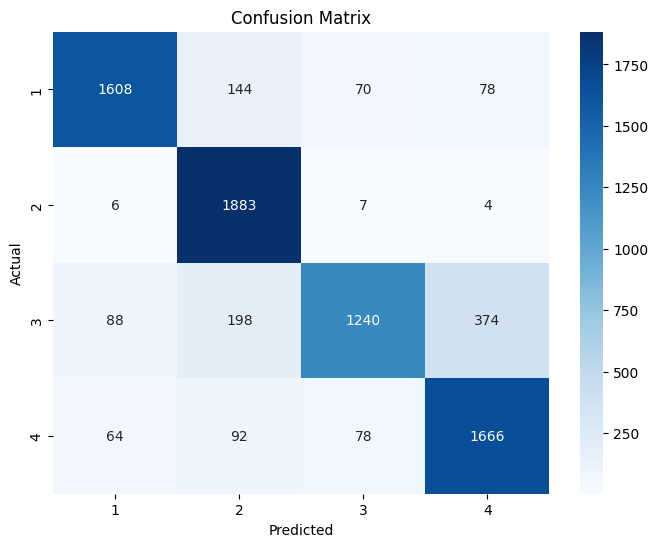

              precision    recall  f1-score   support

           1       0.91      0.85      0.88      1900
           2       0.81      0.99      0.89      1900
           3       0.89      0.65      0.75      1900
           4       0.79      0.88      0.83      1900

    accuracy                           0.84      7600
   macro avg       0.85      0.84      0.84      7600
weighted avg       0.85      0.84      0.84      7600



In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

true_labels, pred_labels = [], []

# Mengumpulkan label sebenarnya dan prediksi
for batch in test_loader:
    input_ids = batch["input_ids"].to(DEVICE)
    labels = batch["label"].to(DEVICE)
    with torch.no_grad():
        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(true_labels, pred_labels, target_names=[str(c) for c in label_encoder.classes_]))

In [110]:
# Simpan Model
torch.save(model.state_dict(), "lstm_classifier.pth")
print("Model berhasil disimpan")

Model berhasil disimpan
